## Search for school

In [1]:
import pandas as pd
from urllib.request import urlopen
from json import loads
import pandas as pd

school_df = pd.read_csv("schoolname_UNITID.csv")

def search_school(school_name):
    # Case-insensitive search for school name
    result = school_df[school_df["inst_name"].str.contains(school_name, case=False, na=False)]
    if result.empty:
        print(f"No matches found for '{school_name}'.")
    return result

def get_school_name(unitid):
    # Fetch school directory data
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?unitid={unitid}"
    response = urlopen(url)
    data = loads(response.read())
    
    results = data.get("results", [])
    if results:
        school_name = results[0].get("inst_name", "Unknown")
        return school_name
    else:
        return f"No school found for unitid {unitid}"

search_school("New Jersey")


,unitid,inst_name
2028,185129,New Jersey City University
2042,185828,New Jersey Institute of Technology
2051,186201,Ramapo College of New Jersey
2067,186900,Talmudical Academy-New Jersey
2070,187134,The College of New Jersey
2072,187444,William Paterson University of New Jersey
4782,445300,University of Phoenix-New Jersey
5056,453215,Strayer University-New Jersey
5710,482556,DeVry University-New Jersey
5927,486956,Chamberlain University-New Jersey


## Tuition Fees vs. Student Enrollment
<br>**Purpose**
<br>Displays the relationship between tuition fees and student enrollment for different institutions
<br>**Insight**
<br>Helps identify patterns, such as whether higher tuition fees correlate with higher or lower enrollments.

In [2]:
from urllib.request import urlopen
from json import loads
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# Function to fetch data for a specific year
def fetch_data(year):
    # Fetch tuition data
    tuition_url = (
        f"https://educationdata.urban.org/api/v1/college-university/ipeds/academic-year-tuition/summaries"
        f"?var=tuition_fees_published&stat=avg&by=unitid,inst_control&year={year}"
    )
    tuition_response = urlopen(tuition_url)
    tuition_data = loads(tuition_response.read())

    # Fetch enrollment data
    enrollment_url = (
        f"https://educationdata.urban.org/api/v1/college-university/ipeds/enrollment-full-time-equivalent/summaries"
        f"?var=est_fte&stat=sum&by=unitid,inst_control&year={year}"
    )
    enrollment_response = urlopen(enrollment_url)
    enrollment_data = loads(enrollment_response.read())

    return pd.DataFrame(tuition_data.get("results", [])), pd.DataFrame(enrollment_data.get("results", []))

# Function to process and plot data for the selected year
def plot_data(year):
    # Fetch the data for the specified year
    tuition_df, enrollment_df = fetch_data(year)

    # Merge data on 'unitid' and 'inst_control'
    merged_df = pd.merge(tuition_df, enrollment_df, on=["unitid", "inst_control"], how="inner")

    merged_df.rename(
        columns={
            "tuition_fees_published": "tuition_fees",
            "est_fte": "enrollment",
            "inst_control": "institution_type",
        },
        inplace=True,
    )


    control_map = {
        1: "Public",
        2: "Private Nonprofit",
        3: "Private For-Profit",
    }
    merged_df["institution_type"] = merged_df["institution_type"].map(control_map)

    # Filter out outliers
    merged_df = merged_df[(merged_df["tuition_fees"] <= 70000) & (merged_df["enrollment"] <= 50000)]

    # Visualization: Tuition vs. Enrollment by Institution Type
    plt.figure(figsize=(10, 6))
    for inst_type in merged_df["institution_type"].unique():
        subset = merged_df[merged_df["institution_type"] == inst_type]
        plt.scatter(subset["tuition_fees"], subset["enrollment"], alpha=0.7, label=inst_type)

    plt.title(f"Tuition Fees vs. Student Enrollment ({year})", fontsize=14)
    plt.xlabel("Tuition Fees (in USD)", fontsize=12)
    plt.ylabel("Student Enrollment", fontsize=12)
    plt.legend(title="Institution Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Binning tuition fees
    merged_df["tuition_bin"] = pd.cut(merged_df["tuition_fees"], bins=range(0, 80000, 10000))

    # Grouping and plotting average enrollment by tuition bin and institution type
    grouped = merged_df.groupby(["tuition_bin", "institution_type"])["enrollment"].mean().unstack()


    grouped.plot(kind="bar", figsize=(12, 6), colormap="tab10")
    plt.title(f"Average Enrollment by Tuition Fee Range and Institution Type ({year})")
    plt.xlabel("Tuition Fee Range (in USD)")
    plt.ylabel("Average Enrollment")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create an interactive dropdown for the year
interact(plot_data, year=[2010, 2012, 2014, 2016, 2018, 2020])


interactive(children=(Dropdown(description='year', options=(2010, 2012, 2014, 2016, 2018, 2020), value=2010), …

<function __main__.plot_data(year)>

In [13]:
SCHOOL_UNITID = 185828  # NJIT
SCHOOL_NAME = get_school_name(SCHOOL_UNITID)

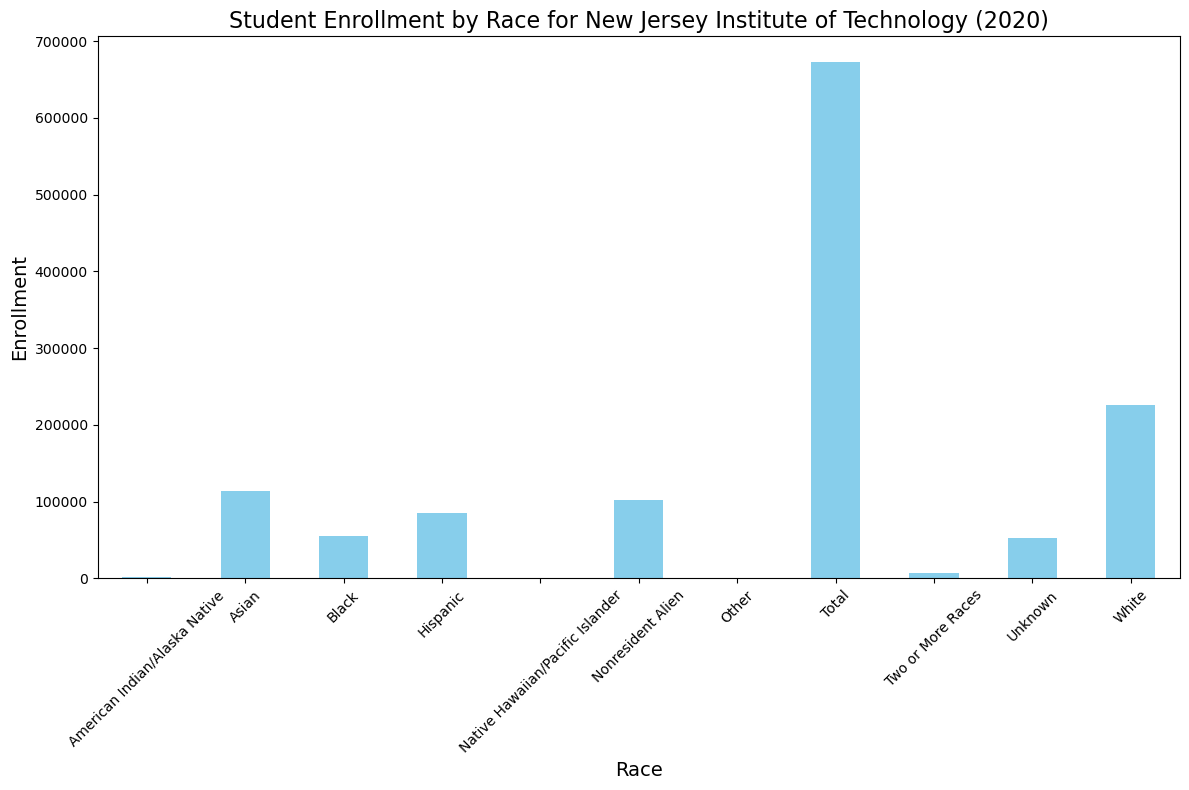

In [5]:
from urllib.request import urlopen
from json import loads
import pandas as pd
import matplotlib.pyplot as plt

url = (
    f"https://educationdata.urban.org/api/v1/college-university/ipeds/fall-enrollment/race/summaries"
    f"?var=enrollment_fall&stat=sum&by=race,unitid&unitid={SCHOOL_UNITID}"
)
response = urlopen(url)
data = loads(response.read())

df = pd.DataFrame(data.get("results", []))

# Map race codes to descriptive names (as per documentation)
race_map = {
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "American Indian/Alaska Native",
    6: "Native Hawaiian/Pacific Islander",
    7: "Two or More Races",
    8: "Nonresident Alien",
    9: "Unknown",
    20: "Other",
    99: "Total"
}

df["race"] = df["race"].map(race_map)

# Group by race, summing enrollment
grouped = df.groupby(["race"])["enrollment_fall"].sum()

# Plot bar chart for race distribution
plt.figure(figsize=(12, 8))
grouped.plot(kind="bar", color="skyblue")
plt.title(f"Student Enrollment by Race for {SCHOOL_NAME} (2020)", fontsize=16)
plt.xlabel("Race", fontsize=14)
plt.ylabel("Enrollment", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Retention Rate

### Retention Rate over time for specific institution

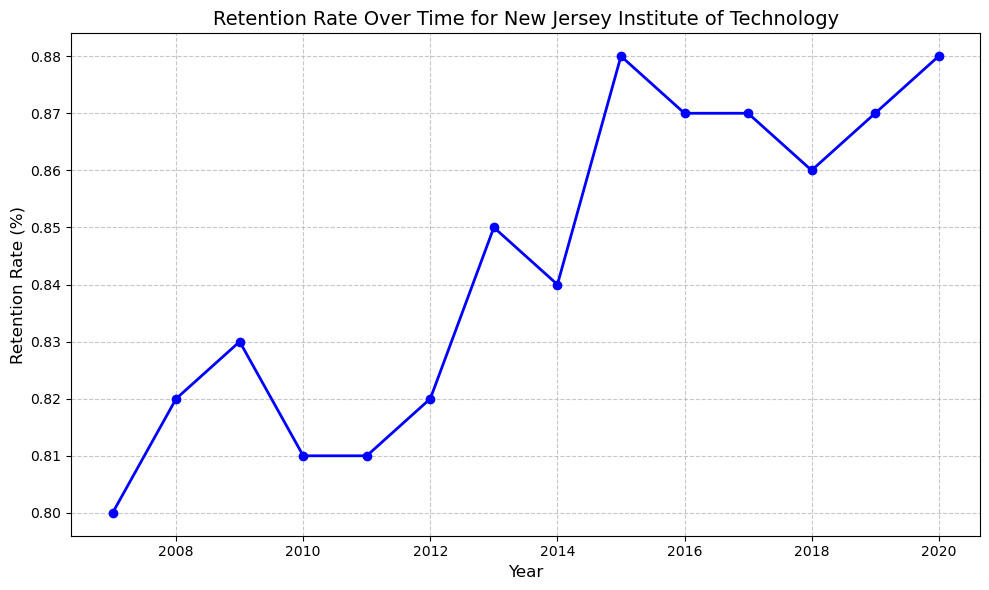

In [14]:
url = (
    f"https://educationdata.urban.org/api/v1/college-university/ipeds/fall-retention/summaries"
    f"?var=retention_rate&stat=avg&by=unitid,year&unitid={SCHOOL_UNITID}"
)
response = urlopen(url)
data = loads(response.read())

df = pd.DataFrame(data.get("results", []))

if df.empty:
    print(f"No data available for school with {SCHOOL_NAME}.")
else:
    # Group by year and calculate the average retention rate (if needed)
    grouped_time = df.groupby("year")["retention_rate"].mean()

    # Plot the retention rate over time
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_time.index, grouped_time.values, marker="o", color="blue", linewidth=2)
    plt.title(f"Retention Rate Over Time for {SCHOOL_NAME}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Retention Rate (%)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


### Retention Rates over time for Institution types
<br>**Purpose**
<br>This graph shows retention rates over time for different institution types (e.g., Public, Private Nonprofit, Private For-Profit) and overlays the retention rate trend for a specific institution: New Jersey Institute of Technology (NJIT).
<br>**Insights**
<br>- Private Nonprofit institutions lead in retention
<br>- Public institutions show moderate improvement
<br>- NJIT's Retention Rate Outperforms the Average for Public Institutions

Note: might try to compare with the institutions in the top 100

<Figure size 1200x600 with 0 Axes>

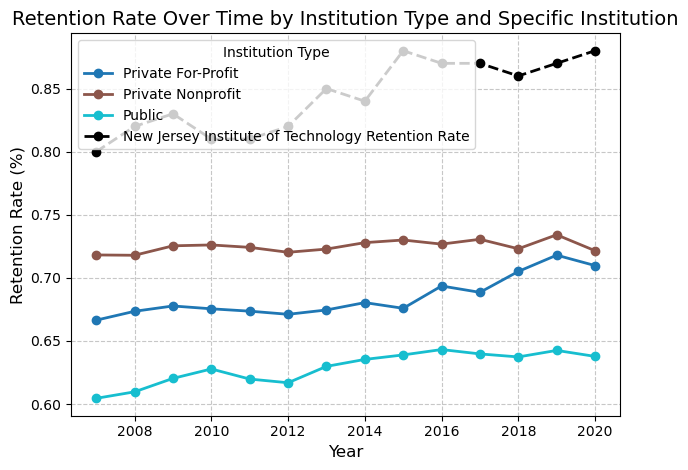

In [15]:
url = (
    "https://educationdata.urban.org/api/v1/college-university/ipeds/fall-retention/summaries"
    "?var=retention_rate&stat=avg&by=inst_control,year"
)
response = urlopen(url)
data = loads(response.read())
df = pd.DataFrame(data.get("results", []))

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-Profit"
}

df["institution_type"] = df["inst_control"].map(control_map)

# Group by year and institution type, then calculate average retention rate
grouped_time = df.groupby(["year", "institution_type"])["retention_rate"].mean().unstack()

school_url = (
    f"https://educationdata.urban.org/api/v1/college-university/ipeds/fall-retention/summaries"
    f"?var=retention_rate&stat=avg&by=unitid,year&unitid={SCHOOL_UNITID}"
)
school_response = urlopen(school_url)
school_data = loads(school_response.read())
school_df = pd.DataFrame(school_data.get("results", []))

# Plot the multi-institution retention rates
plt.figure(figsize=(12, 6))
grouped_time.plot(kind="line", marker="o", colormap="tab10", linewidth=2)

# Plot the specific school's retention rate
if not school_df.empty:
    school_grouped_time = school_df.groupby("year")["retention_rate"].mean()
    plt.plot(
        school_grouped_time.index,
        school_grouped_time.values,
        marker="o",
        color="black",
        linewidth=2,
        linestyle="--",
        label=f"{SCHOOL_NAME} Retention Rate"
    )
else:
    print(f"No retention data available for {SCHOOL_NAME}.")

plt.title("Retention Rate Over Time by Institution Type and Specific Institution", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Retention Rate (%)", fontsize=12)
plt.legend(title="Institution Type", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\thaou\AppData\Local\Temp\ipykernel_23744\2155360803.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=types, patch_artist=True, boxprops=dict(facecolor="lightblue"))


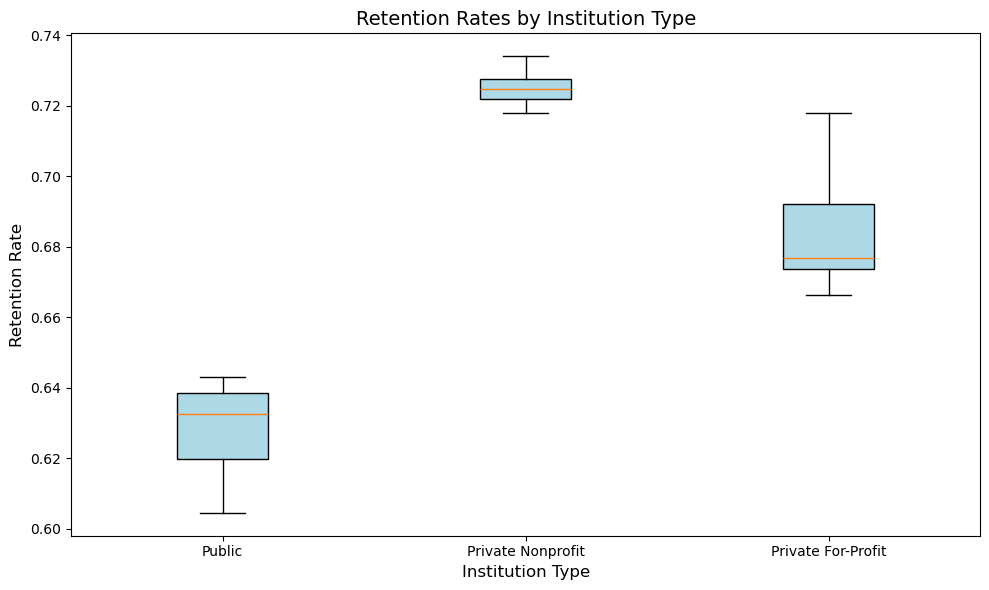

In [16]:
# Box plot
types = df["institution_type"].unique()
data = [df[df["institution_type"] == t]["retention_rate"] for t in types]

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=types, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Retention Rates by Institution Type", fontsize=14)
plt.xlabel("Institution Type", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.tight_layout()
plt.show()


### Tuition Fees vs. Avg Retention Rate
<br>**Purpose**
<br>Shows how retention rates vary across different levels of tuition fees.
<br>**Insights**
<br>- Retention Rate Increases with Tuition Fee Range
<br>- Drop in Retention for the Highest Tuition Range

/tmp/ipykernel_35583/3047188506.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = merged_df.groupby("tuition_bin")["retention_rate"].mean().reset_index()


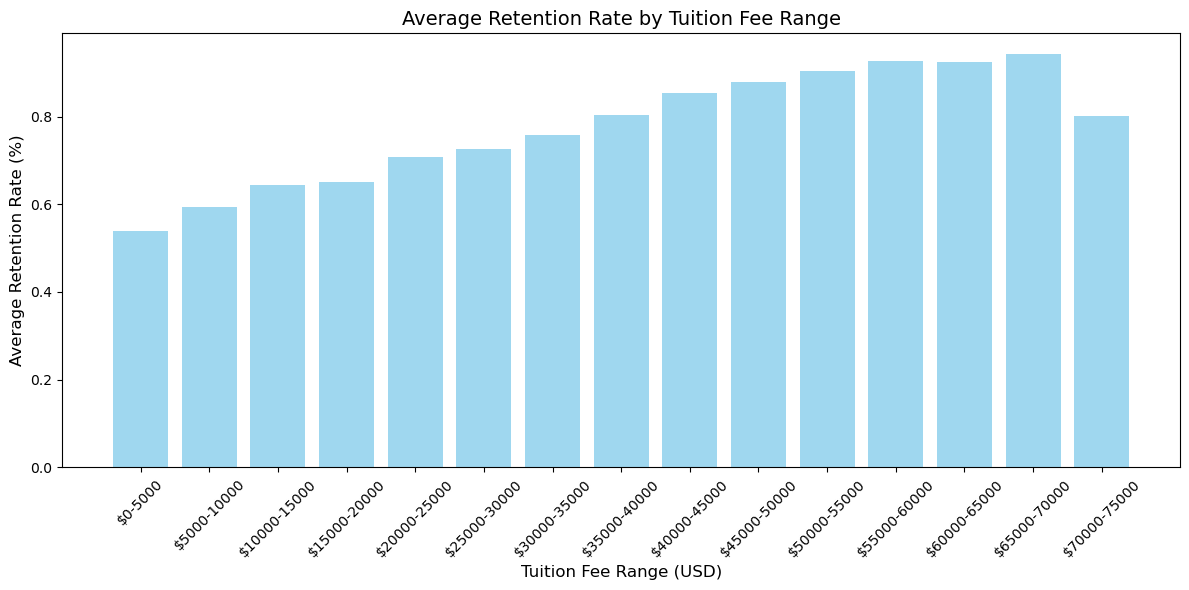

In [79]:
from urllib.request import urlopen
from json import loads
import pandas as pd
import matplotlib.pyplot as plt

# Fetch retention data
retention_url = "https://educationdata.urban.org/api/v1/college-university/ipeds/fall-retention/summaries?var=retention_rate&stat=avg&by=unitid"
retention_response = urlopen(retention_url)
retention_data = loads(retention_response.read())
retention_df = pd.DataFrame(retention_data.get("results", []))

# Fetch tuition data
tuition_url = "https://educationdata.urban.org/api/v1/college-university/ipeds/academic-year-tuition/summaries?var=tuition_fees_published&stat=avg&by=unitid"
tuition_response = urlopen(tuition_url)
tuition_data = loads(tuition_response.read())
tuition_df = pd.DataFrame(tuition_data.get("results", []))

# Merge datasets on 'unitid'
merged_df = pd.merge(retention_df, tuition_df, on="unitid", suffixes=("_retention", "_tuition"))

# Bin tuition fees into ranges
bins = range(0, 80000, 5000)  # Tuition bins of $5000 intervals
labels = [f"${i}-{i+5000}" for i in bins[:-1]]
merged_df["tuition_bin"] = pd.cut(merged_df["tuition_fees_published"], bins=bins, labels=labels, include_lowest=True)

# Calculate average retention rate per bin
binned_data = merged_df.groupby("tuition_bin")["retention_rate"].mean().reset_index()

# Plot aggregated data
plt.figure(figsize=(12, 6))
plt.bar(binned_data["tuition_bin"], binned_data["retention_rate"], color="skyblue", alpha=0.8)
plt.title("Average Retention Rate by Tuition Fee Range", fontsize=14)
plt.xlabel("Tuition Fee Range (USD)", fontsize=12)
plt.ylabel("Average Retention Rate (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Average Grant Amounts Over Time
<br>**Insights**
<br>- Private nonprofit institutions receive the most grants while minimal grants for public institutions
<br>- Increasing trend in grant amount.

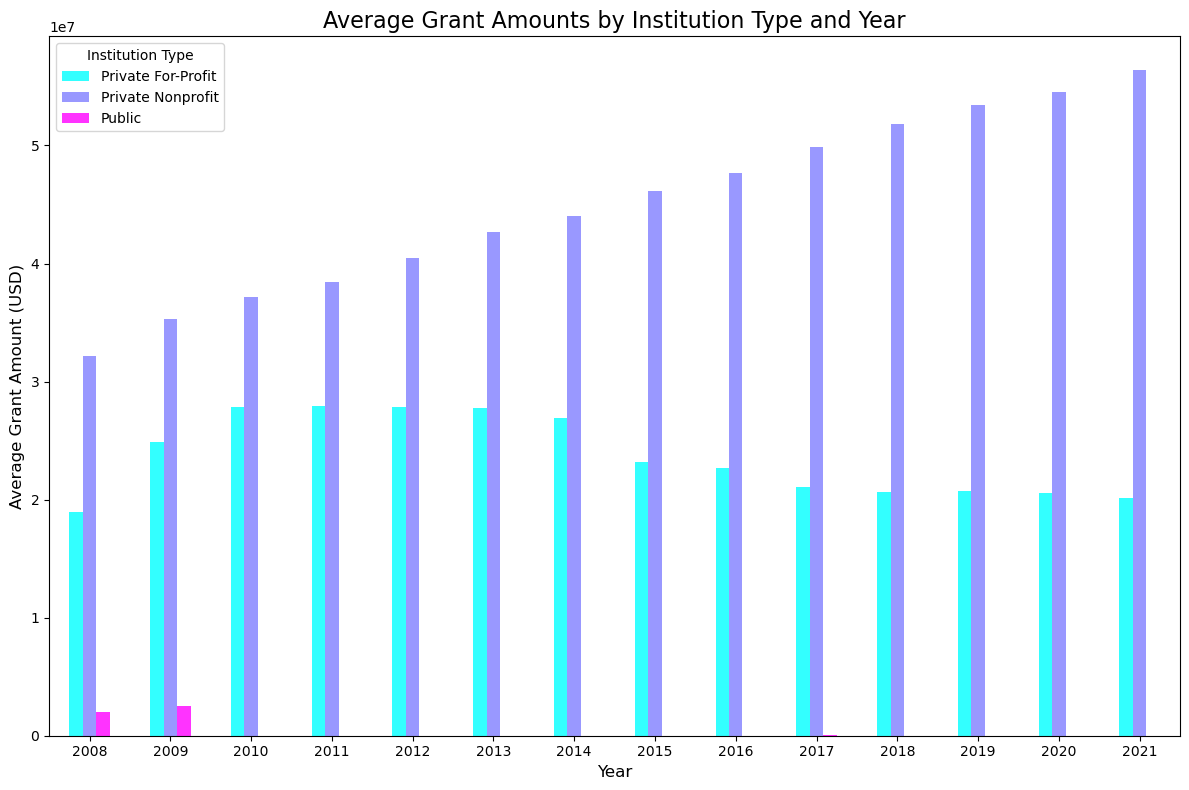

In [25]:
from urllib.request import urlopen
from json import loads
import pandas as pd
import matplotlib.pyplot as plt

# Fetch student aid data (average grant amounts)
aid_url = "https://educationdata.urban.org/api/v1/college-university/ipeds/sfa-grants-and-net-price/summaries?var=average_grant&stat=sum&by=inst_control"
aid_response = urlopen(aid_url)
aid_data = loads(aid_response.read())
aid_df = pd.DataFrame(aid_data.get("results", []))

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-Profit"
}

aid_df["institution_type"] = aid_df["inst_control"].map(control_map)
aid_df = aid_df.dropna(subset=["institution_type", "average_grant"])

# Group by year and institution type
aid_df["institution_type"] = aid_df["inst_control"].map(control_map)
grouped = aid_df.groupby(["year", "institution_type"])["average_grant"].sum().unstack()

# Plot grouped bar chart
grouped.plot(kind="bar", figsize=(12, 8), colormap="cool", alpha=0.8)
plt.title("Average Grant Amounts by Institution Type and Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Grant Amount (USD)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Institution Type", fontsize=10)
plt.tight_layout()
plt.show()


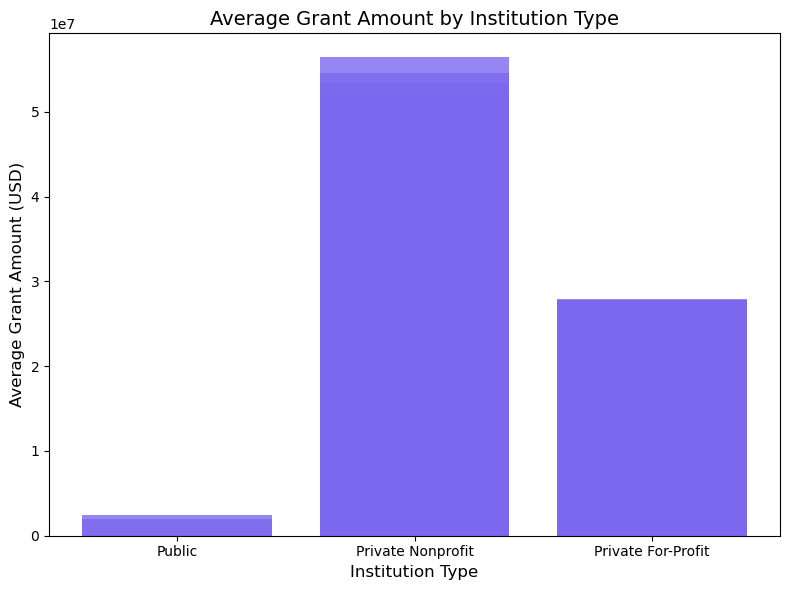

In [38]:
# Plot the bar chart again with consistent colors
plt.figure(figsize=(8, 6))
plt.bar(aid_df["institution_type"], aid_df["average_grant"], color='mediumslateblue', alpha=0.8)
plt.title("Average Grant Amount by Institution Type", fontsize=14)
plt.xlabel("Institution Type", fontsize=12)
plt.ylabel("Average Grant Amount (USD)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## SAT

<Figure size 1200x800 with 0 Axes>

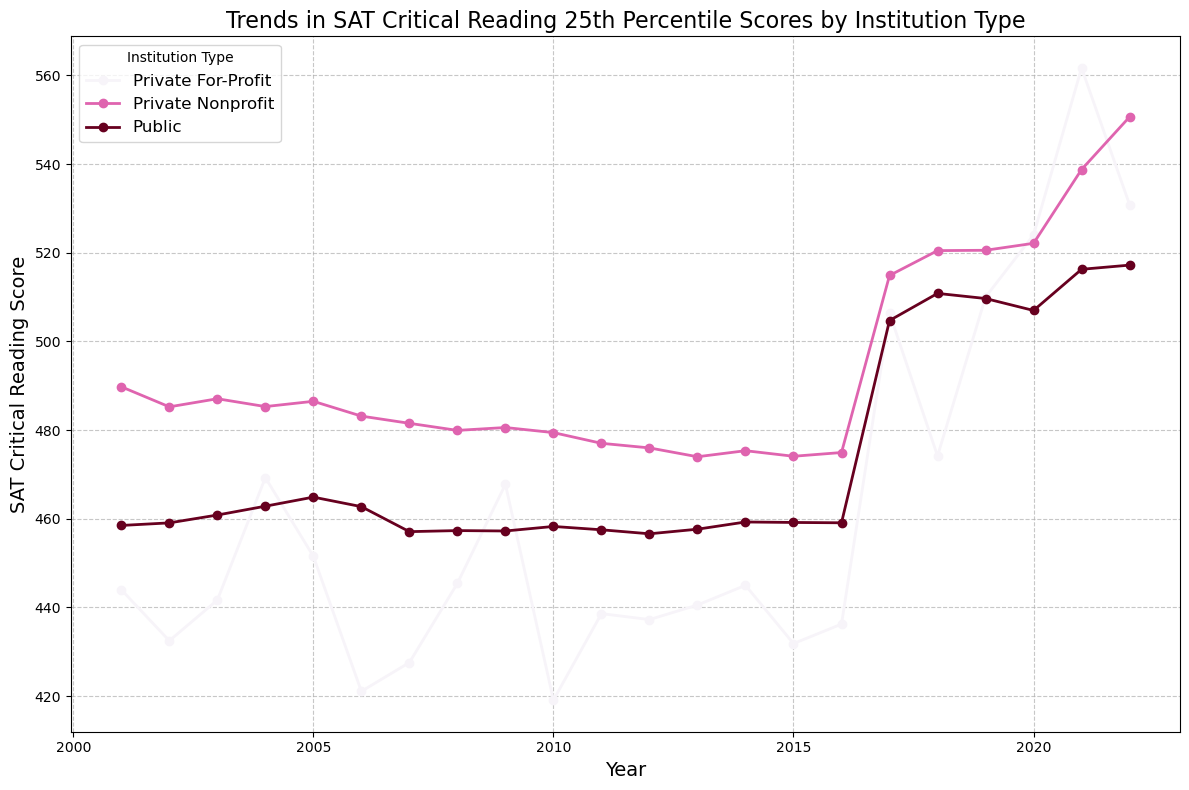

In [43]:
from urllib.request import urlopen
from json import loads
import pandas as pd
import matplotlib.pyplot as plt

# Fetch SAT critical reading 25th percentile scores by institution type and year
url = "https://educationdata.urban.org/api/v1/college-university/ipeds/admissions-requirements/summaries?var=sat_crit_read_25_pctl&stat=avg&by=inst_control,year"
response = urlopen(url)
data = loads(response.read())


df = pd.DataFrame(data.get("results", []))

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-Profit"
}
df["institution_type"] = df["inst_control"].map(control_map)
df = df[(df["sat_crit_read_25_pctl"] > 0) & (df["year"] > 0)] # Remove missing values

# Pivot the data for visualization
pivot_df = df.pivot(index="year", columns="institution_type", values="sat_crit_read_25_pctl")

# Plot
plt.figure(figsize=(12, 8))
pivot_df.plot(kind="line", marker="o", linewidth=2, figsize=(12, 8), colormap="PuRd")
plt.title("Trends in SAT Critical Reading 25th Percentile Scores by Institution Type", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("SAT Critical Reading Score", fontsize=14)
plt.legend(title="Institution Type", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


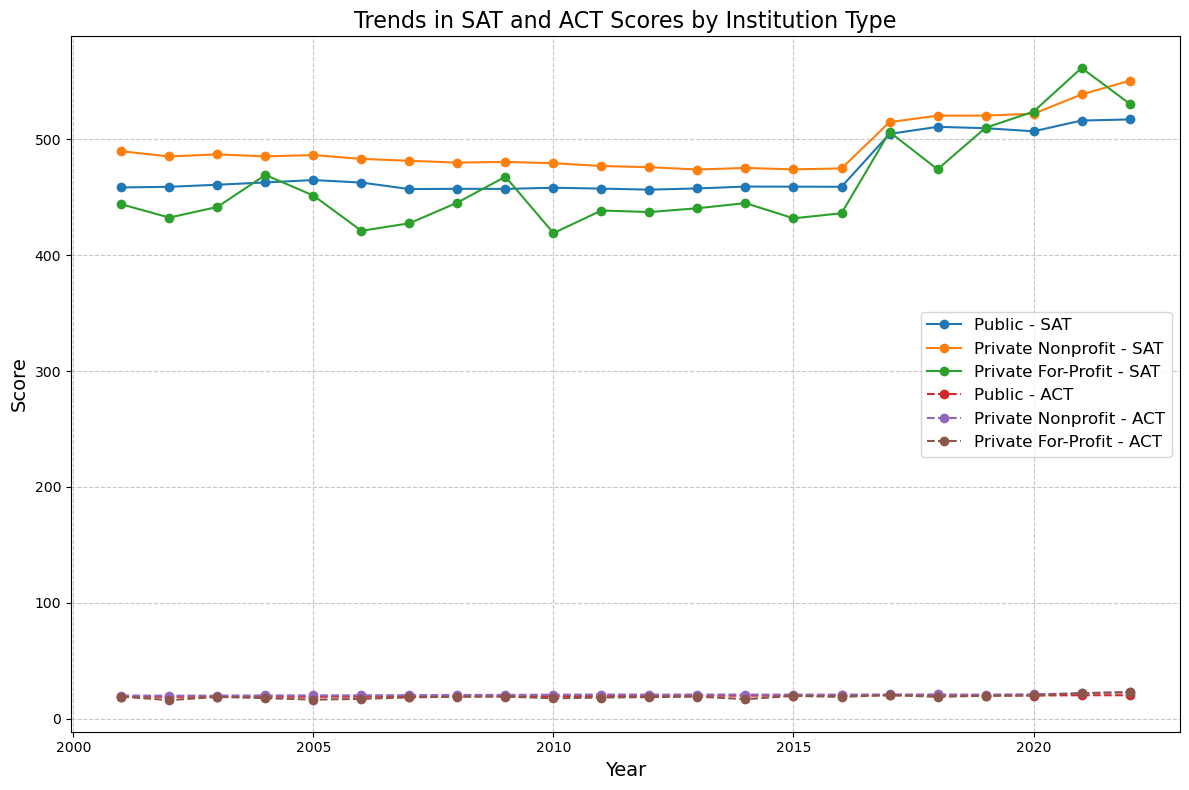

In [44]:
# Fetch SAT critical reading and ACT composite 25th percentile scores by institution type and year
sat_url = "https://educationdata.urban.org/api/v1/college-university/ipeds/admissions-requirements/summaries?var=sat_crit_read_25_pctl&stat=avg&by=inst_control,year"
act_url = "https://educationdata.urban.org/api/v1/college-university/ipeds/admissions-requirements/summaries?var=act_composite_25_pctl&stat=avg&by=inst_control,year"

sat_data = loads(urlopen(sat_url).read())
act_data = loads(urlopen(act_url).read())

sat_df = pd.DataFrame(sat_data.get("results", []))
act_df = pd.DataFrame(act_data.get("results", []))

# Map institution control to descriptive names
sat_df["institution_type"] = sat_df["inst_control"].map(control_map)
act_df["institution_type"] = act_df["inst_control"].map(control_map)

# Remove invalid values
sat_df = sat_df[(sat_df["sat_crit_read_25_pctl"] > 0) & (sat_df["year"] > 0)]
act_df = act_df[(act_df["act_composite_25_pctl"] > 0) & (act_df["year"] > 0)]

# Plot trends over time
plt.figure(figsize=(12, 8))
for inst_type in sat_df["institution_type"].unique():
    subset = sat_df[sat_df["institution_type"] == inst_type]
    plt.plot(subset["year"], subset["sat_crit_read_25_pctl"], label=f"{inst_type} - SAT", marker="o")
for inst_type in act_df["institution_type"].unique():
    subset = act_df[act_df["institution_type"] == inst_type]
    plt.plot(subset["year"], subset["act_composite_25_pctl"], label=f"{inst_type} - ACT", marker="o", linestyle="--")

plt.title("Trends in SAT and ACT Scores by Institution Type", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Number of SAT submissions over time
<br>**Purpose**
<br>This graph can help admissions offices analyze how their policies align with broader trends in SAT submissions and recommendations.
<br>**Insights**
<br>- Dominance of "Neither Required Nor Recommended": The orange line, representing institutions where recommendations are neither required nor recommended, consistently has the highest number of SAT submissions. Many institutions either don't priortize recommendations or attract students regardless of this factor
<br>- Decline in SAT Submissions for "Required" and "Recommended" Categories (Post-2015):
<br>This could reflect a broader shift away from SAT requirements or changes in institutional admissions policies.
<br>- COVID-19 Pandemic:
The sharp drop in 2020 can largely be attributed to the pandemic, where many students could not sit for standardized tests, and institutions temporarily waived SAT/ACT requirements.

Columns in the dataset: Index(['year', 'reqt_recommendations', 'sat_number_submitting'], dtype='object')
   year  reqt_recommendations  sat_number_submitting
0  2001                    -1                  31015
1  2001                     0                 271193
2  2001                     1                 222855
3  2001                     2                 177875
4  2002                    -1                   3753


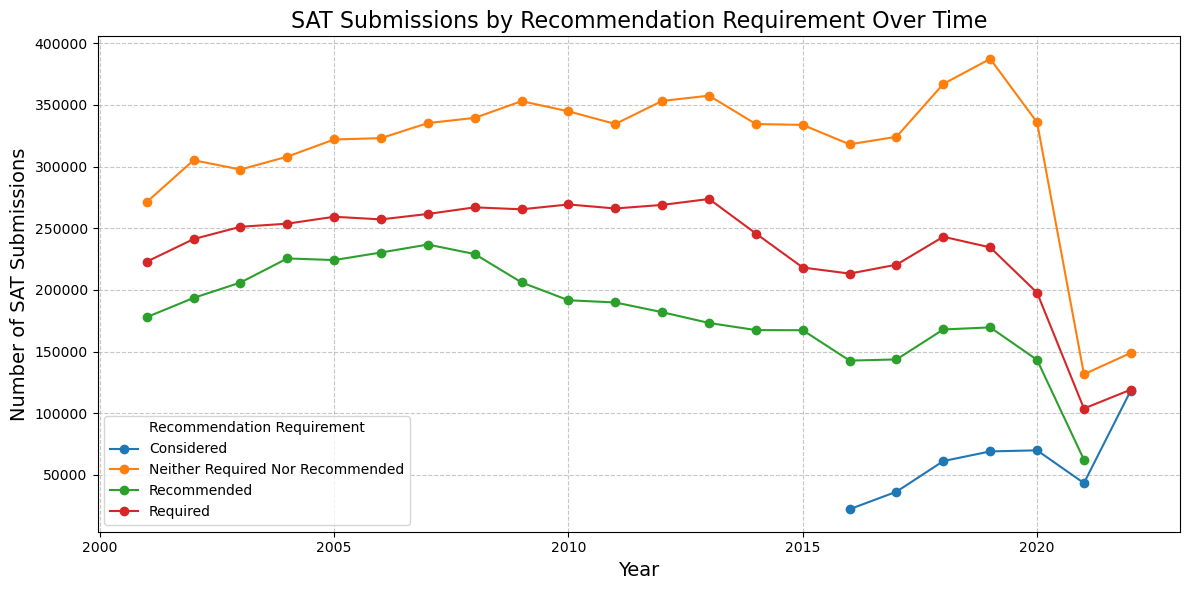

In [52]:
url = (
    "https://educationdata.urban.org/api/v1/college-university/ipeds/admissions-requirements/summaries"
    "?var=sat_number_submitting&stat=sum&by=reqt_recommendations,year"
)
response = urlopen(url)
data = loads(response.read())

# Load data into DataFrame
df = pd.DataFrame(data.get("results", []))

print("Columns in the dataset:", df.columns)
print(df.head())

recommendation_map = {
    0: "Neither Required Nor Recommended",
    1: "Required",
    2: "Recommended",
    3: "Considered"
}
df["recommendation_label"] = df["reqt_recommendations"].map(recommendation_map)

# Filter out invalid recommendation data (-1, -2, -3)
filtered_df = df[df["reqt_recommendations"] >= 0]

# Pivot the data for visualization
pivot_df = filtered_df.pivot(index="year", columns="recommendation_label", values="sat_number_submitting")

# Plot the data
plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column, marker="o")

plt.title("SAT Submissions by Recommendation Requirement Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of SAT Submissions", fontsize=14)
plt.legend(title="Recommendation Requirement", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()